In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time


from random import randint
from numpy import array
from numpy import argmax
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [3]:
data = read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
data = data.drop('No', axis=1, inplace=False)
data = data.drop(['year','month','day','hour'], axis=1, inplace=False)

In [4]:
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [6]:
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
data.head()
# summarize first 5 rows
print(data.head(5))
# save to file
#data.to_csv('pollution.csv')

    pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
48       90.0   -7  -6.0  1027.0      SE    58.56     4     0
49       63.0   -8  -6.0  1026.0      SE    61.69     5     0
50       65.0   -8  -7.0  1026.0      SE    65.71     6     0
51       55.0   -8  -7.0  1025.0      SE    68.84     7     0
52       65.0   -8  -7.0  1024.0      SE    72.86     8     0


#

In [12]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

#use last 10 days of data (240 hours) to predict specifically the pollution 10 days from now (240 hours later)
num_days_back = 10
hrs_per_day = 24
num_days_ahead = 3
reframed = series_to_supervised(values, num_days_back*hrs_per_day, num_days_ahead*hrs_per_day)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
#values = scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

train = values[:n_train_hours, :]
test = values[n_train_hours:, :] #make test set 1 year worth of data
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


     var1(t-240)  var2(t-240)  var3(t-240)  var4(t-240)  var5(t-240)  \
240         90.0         -7.0         -6.0       1027.0          2.0   
241         63.0         -8.0         -6.0       1026.0          2.0   
242         65.0         -8.0         -7.0       1026.0          2.0   
243         55.0         -8.0         -7.0       1025.0          2.0   
244         65.0         -8.0         -7.0       1024.0          2.0   

     var6(t-240)  var7(t-240)  var8(t-240)  var1(t-239)  var2(t-239)  ...  \
240    58.560001          4.0          0.0         63.0         -8.0  ...   
241    61.689999          5.0          0.0         65.0         -8.0  ...   
242    65.709999          6.0          0.0         55.0         -8.0  ...   
243    68.839996          7.0          0.0         65.0         -8.0  ...   
244    72.860001          8.0          0.0         83.0         -9.0  ...   

     var8(t+69)  var1(t+70)  var2(t+70)  var3(t+70)  var4(t+70)  var5(t+70)  \
240         0.0        94

In [13]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128)               1339904   
_________________________________________________________________
dense_21 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 1,346,405
Trainable params: 1,346,405
Non-trainable params: 0
_________________________________________________________________


In [14]:
yhat = model.predict(test_X)

In [15]:
yhat.shape

(17185, 1)

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
print("Activation function = {}, Loss type = {}\n".format(act_fctn, loss_fctn))
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse) 
return rmse

In [ ]:
#print('hiii')
#print(scaled)
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
start = time.time()


history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/andychang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 26280 samples, validate on 17185 samples
Epoch 1/10
26280/26280 [==============================] - 10s 364us/step - loss: 0.0754 - val_loss: 0.0674
Epoch 2/10
26280/26280 [==============================] - 9s 325us/step - loss: 0.0675 - val_loss: 0.0676
Epoch 3/10
26280/26280 [==============================] - 9s 339us/step - loss: 0.0683 - val_loss: 0.0701
Epoch 4/10
26280/26280 [==============================] - 9s 340us/step - loss: 0.0673 - val_loss: 0.0712
Epoch 5/10
26280/26280 [==============================] - 8s 321us/step - loss: 0.0647 - val_loss: 0.0711
Epoch 6/10
26280/26280 [==============================] - 9s 342us/step - loss: 0.0625 - val_loss: 0.0671
Epoch 7/10
26280/26280 [==============================] - 15s 584us/step - loss: 0.0542 - val_loss: 0.0678
Epoch 8/10
26280/26280 [==============================] - 13s 509us/step - loss: 0.0504 - val_loss: 0.0715
Epoch 9/10
26280/26280 [==============================] - 9s 338us/step - loss: 0.0483 - val_loss: 

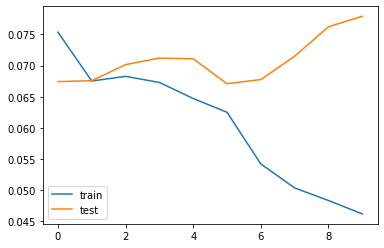

This took 105.2099359035492 seconds.
Activation function = relu, Loss type = mae

Test RMSE: 95.752


/Users/andychang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 26280 samples, validate on 17185 samples
Epoch 1/10
26280/26280 [==============================] - 10s 389us/step - loss: 0.0177 - val_loss: 0.0081
Epoch 2/10
26280/26280 [==============================] - 10s 384us/step - loss: 0.0084 - val_loss: 0.0074
Epoch 3/10
26280/26280 [==============================] - 11s 433us/step - loss: 0.0067 - val_loss: 0.0108
Epoch 4/10
26280/26280 [==============================] - 10s 392us/step - loss: 0.0054 - val_loss: 0.0161
Epoch 5/10
26280/26280 [==============================] - 9s 340us/step - loss: 0.0049 - val_loss: 0.0109
Epoch 6/10
26280/26280 [==============================] - 9s 340us/step - loss: 0.0043 - val_loss: 0.0057
Epoch 7/10
26280/26280 [==============================] - 10s 363us/step - loss: 0.0039 - val_loss: 0.0035
Epoch 8/10
26280/26280 [==============================] - 10s 368us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/10
26280/26280 [==============================] - 9s 336us/step - loss: 0.0033 - val_los

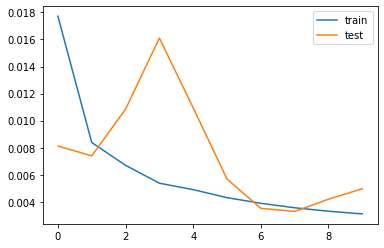

This took 100.79571294784546 seconds.
Activation function = relu, Loss type = mse

Test RMSE: 70.035


/Users/andychang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 26280 samples, validate on 17185 samples
Epoch 1/10
26280/26280 [==============================] - 11s 406us/step - loss: 0.0811 - val_loss: 0.1076
Epoch 2/10
26280/26280 [==============================] - 9s 354us/step - loss: 0.0668 - val_loss: 0.0802
Epoch 3/10
26280/26280 [==============================] - 9s 334us/step - loss: 0.0623 - val_loss: 0.0728
Epoch 4/10
26280/26280 [==============================] - 9s 336us/step - loss: 0.0584 - val_loss: 0.0648
Epoch 5/10
26280/26280 [==============================] - 10s 383us/step - loss: 0.0529 - val_loss: 0.0750
Epoch 6/10
26280/26280 [==============================] - 10s 391us/step - loss: 0.0494 - val_loss: 0.0803
Epoch 7/10
26280/26280 [==============================] - 10s 398us/step - loss: 0.0447 - val_loss: 0.0682
Epoch 8/10
26280/26280 [==============================] - 9s 339us/step - loss: 0.0451 - val_loss: 0.0677
Epoch 9/10
26280/26280 [==============================] - 8s 323us/step - loss: 0.0440 - val_loss:

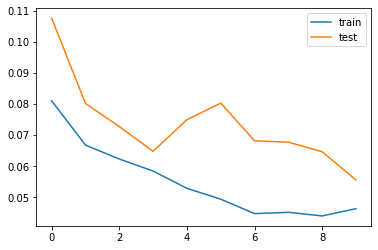

This took 97.05134892463684 seconds.
Activation function = sigmoid, Loss type = mae

Test RMSE: 73.935


/Users/andychang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 26280 samples, validate on 17185 samples
Epoch 1/10
26280/26280 [==============================] - 10s 375us/step - loss: 0.0130 - val_loss: 0.0069
Epoch 2/10
26280/26280 [==============================] - 9s 347us/step - loss: 0.0088 - val_loss: 0.0058
Epoch 3/10
26280/26280 [==============================] - 9s 324us/step - loss: 0.0065 - val_loss: 0.0050
Epoch 4/10
26280/26280 [==============================] - 8s 312us/step - loss: 0.0053 - val_loss: 0.0071
Epoch 5/10
26280/26280 [==============================] - 8s 313us/step - loss: 0.0046 - val_loss: 0.0110
Epoch 6/10
26280/26280 [==============================] - 9s 335us/step - loss: 0.0044 - val_loss: 0.0097
Epoch 7/10
26280/26280 [==============================] - 8s 323us/step - loss: 0.0042 - val_loss: 0.0098
Epoch 8/10
26280/26280 [==============================] - 9s 346us/step - loss: 0.0037 - val_loss: 0.0120
Epoch 9/10
26280/26280 [==============================] - 9s 354us/step - loss: 0.0035 - val_loss: 0.

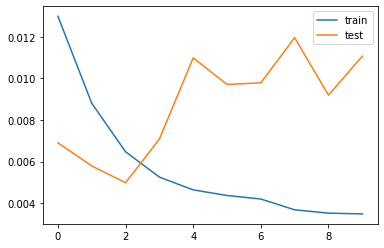

This took 91.889719247818 seconds.
Activation function = sigmoid, Loss type = mse

Test RMSE: 104.549


/Users/andychang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 26280 samples, validate on 17185 samples
Epoch 1/10
26280/26280 [==============================] - 10s 369us/step - loss: 0.0675 - val_loss: 0.0679
Epoch 2/10
26280/26280 [==============================] - 9s 341us/step - loss: 0.0669 - val_loss: 0.0676
Epoch 3/10
26280/26280 [==============================] - 9s 343us/step - loss: 0.0671 - val_loss: 0.0680
Epoch 4/10
26280/26280 [==============================] - 9s 345us/step - loss: 0.0671 - val_loss: 0.0678
Epoch 5/10
26280/26280 [==============================] - 9s 347us/step - loss: 0.0671 - val_loss: 0.0677
Epoch 6/10
26280/26280 [==============================] - 9s 341us/step - loss: 0.0672 - val_loss: 0.0676
Epoch 7/10
26280/26280 [==============================] - 9s 352us/step - loss: 0.0671 - val_loss: 0.0676
Epoch 8/10
26280/26280 [==============================] - 9s 358us/step - loss: 0.0672 - val_loss: 0.0675
Epoch 9/10
26280/26280 [==============================] - 12s 439us/step - loss: 0.0672 - val_loss: 0

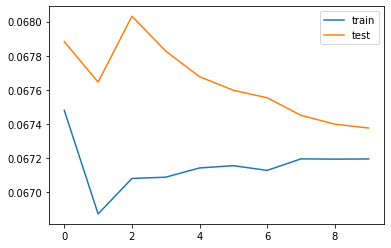

This took 98.0994303226471 seconds.
Activation function = softmax, Loss type = mae

Test RMSE: 102.667


/Users/andychang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 26280 samples, validate on 17185 samples
Epoch 1/10
26280/26280 [==============================] - 9s 352us/step - loss: 0.0090 - val_loss: 0.0086
Epoch 2/10
26280/26280 [==============================] - 8s 303us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 3/10
26280/26280 [==============================] - 9s 338us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 4/10
26280/26280 [==============================] - 9s 333us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 5/10
26280/26280 [==============================] - 8s 323us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 6/10
26280/26280 [==============================] - 9s 344us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 7/10
26280/26280 [==============================] - 10s 386us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 8/10
26280/26280 [==============================] - 11s 424us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 9/10
26280/26280 [==============================] - 9s 343us/step - loss: 0.0088 - val_loss: 0

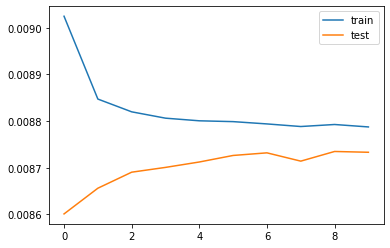

This took 95.63454222679138 seconds.
Activation function = softmax, Loss type = mse

Test RMSE: 92.891


/Users/andychang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 26280 samples, validate on 17185 samples
Epoch 1/10
26280/26280 [==============================] - 11s 431us/step - loss: 0.0815 - val_loss: 0.0678
Epoch 2/10
26280/26280 [==============================] - 10s 372us/step - loss: 0.0695 - val_loss: 0.0647
Epoch 3/10
26280/26280 [==============================] - 9s 336us/step - loss: 0.0667 - val_loss: 0.0676
Epoch 4/10
26280/26280 [==============================] - 9s 334us/step - loss: 0.0675 - val_loss: 0.0676
Epoch 5/10
26280/26280 [==============================] - 8s 306us/step - loss: 0.0675 - val_loss: 0.0675
Epoch 6/10
26280/26280 [==============================] - 8s 307us/step - loss: 0.0674 - val_loss: 0.0677
Epoch 7/10
26280/26280 [==============================] - 9s 323us/step - loss: 0.0674 - val_loss: 0.0678
Epoch 8/10
26280/26280 [==============================] - 8s 320us/step - loss: 0.0673 - val_loss: 0.0679
Epoch 9/10
26280/26280 [==============================] - 9s 333us/step - loss: 0.0673 - val_loss: 0

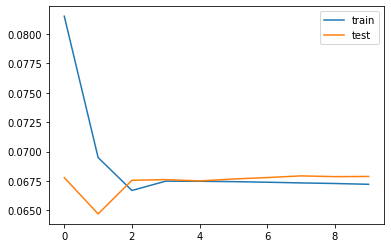

This took 92.15767216682434 seconds.
Activation function = tanh, Loss type = mae

Test RMSE: 103.648


/Users/andychang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 26280 samples, validate on 17185 samples
Epoch 1/10
26280/26280 [==============================] - 13s 497us/step - loss: 0.0255 - val_loss: 0.0086
Epoch 2/10
26280/26280 [==============================] - 9s 335us/step - loss: 0.0100 - val_loss: 0.0086
Epoch 3/10
26280/26280 [==============================] - 9s 356us/step - loss: 0.0101 - val_loss: 0.0086
Epoch 4/10
26280/26280 [==============================] - 9s 345us/step - loss: 0.0101 - val_loss: 0.0086
Epoch 5/10
26280/26280 [==============================] - 8s 316us/step - loss: 0.0101 - val_loss: 0.0086
Epoch 6/10
26280/26280 [==============================] - 9s 336us/step - loss: 0.0098 - val_loss: 0.0086
Epoch 7/10
26280/26280 [==============================] - 9s 350us/step - loss: 0.0101 - val_loss: 0.0086
Epoch 8/10
26280/26280 [==============================] - 9s 324us/step - loss: 0.0100 - val_loss: 0.0085
Epoch 9/10
26280/26280 [==============================] - 8s 305us/step - loss: 0.0099 - val_loss: 0.

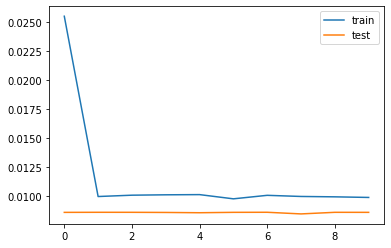

This took 94.0058970451355 seconds.
Activation function = tanh, Loss type = mse

Test RMSE: 92.216
[95.75206529267398, 70.0354681349029, 73.93496072879697, 104.54919035136045, 102.66706564028944, 92.89115459268713, 103.64809566207668, 92.21588016544385]


In [8]:

def try_lstm(train_X, train_y, test_X, test_y, act_fctn, loss_fctn):
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(50, activation=act_fctn))
    model.add(Dense(1))
    model.compile(loss=loss_fctn, optimizer='adam')
    # fit network
    start = time.time()
    
    history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), 
                        verbose=1, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    end = time.time()
    print('This took {} seconds.'.format(end - start))
    # calculate RMSE
    print("Activation function = {}, Loss type = {}\n".format(act_fctn, loss_fctn))
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse) 
    return rmse
    

def try_diff_lstms(train_X, train_y, test_X, test_y):
    act_fctn_list = ['relu', 'sigmoid', 'softmax', 'tanh']
    loss_list = ['mae', 'mse']
    rmse_list = []
    rmse = 0.0
    for act_fctn in act_fctn_list:
        for loss in loss_list:
            rmse = try_lstm(train_X, train_y, test_X, test_y, str(act_fctn), str(loss))
            rmse_list += [rmse,]
    print(rmse_list)
    
    

n_train_hours = (365 * 24) * 3 #make training set 3 years worth of data
train = values[:n_train_hours, :]
test = values[n_train_hours:, :] #make test set 1 year worth of data


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
try_diff_lstms(train_X, train_y, test_X, test_y)

In [10]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               1339904   
_________________________________________________________________
dense_17 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 1,346,405
Trainable params: 1,346,405
Non-trainable params: 0
_________________________________________________________________
